In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [ ]:
chars = sorted(list(set(''.join(words))))
stio = {s:i+1 for i,s in enumerate(chars)}
stio['.']=0
iots = {i:s for s,i in stio.items()}
print(iots)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
#building dataset
block_size = 3
X, Y = [],[]

for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w +'.':
        ix = stio[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(iots[i] for i in context),'---->',iots[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
def build_dataset(words):
    
    block_size = 3
    X, Y = [],[]

    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = stio[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(iots[i] for i in context),'---->',iots[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xts, Yts = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
X.shape, X.dtype, Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
c =torch.randn((27,2))
emb = c[X]
emb.shape

torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn((6,100))
b1 = torch.randn(100)

the W1 dimention is determined by the inputs;Here we have 2 dimentinal embedding with 3 inputs(charcters).  
So the W1 will be (3x2=6), then the second dim is our parameter of how many neurons we want, lets say 100.  
* but if we simply multiply(dot product) the emb(shape[32,3,2]) with W1(shape[6,100]), we will get an error.
concaticating the embedding inputs is needed. 
- we can use pytorch for this.

In [ ]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [ ]:
#but this restrict as in changing the block size easily
torch.cat([emb[:,0,:],emb[:,1,:], emb[:,2,:]],1).shape

torch.Size([32, 6])

In [ ]:
# torch unbind lets us easily change the blocksize and dont hardcode it
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [ ]:
a =torch.arange(18);a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [ ]:
a.view(6,3)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]])

- the internal storage of memory of the variable is unchanged when we call .view just the attributes
 refer is article [http://blog.ezyang.com/2019/05/pytorch-internals/]

In [ ]:
a.storage()

 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

- emb.view(32,6) == torch.cat(torch.unbind(emb,1),1)
it gives us the same result

In [ ]:
#emb.view(emb.shape[0],6)
h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [ ]:
h.shape

torch.Size([32, 100])

In [ ]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
counts = logits.exp()

sum(keepdims=True)... is for not making braodcasting bug, adds dimention size 1 axes (27,1)  
* coz broadcating starts from rigth to left so (27) is changed to as (1,27), keepdims addes trailing size one axes

In [ ]:
probs = counts / counts.sum(1,keepdims=True) # .exp and normalizing by sum gives us softmax

In [ ]:
loss = -probs[torch.arange(32),Y].log().mean() #nll
loss

tensor(17.4144)

In [ ]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

## --------!-----!---

In [ ]:
Xtr.shape,Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [ ]:
g= torch.Generator().manual_seed(2147483647)
C =torch.randn((27,10),generator=g)
W1 = torch.randn((30,200),generator=g) # here we increased the embedding size from 2-->10, W1 will was (2x3=6 Now= 10x3=30)
b1 = torch.randn(200,generator=g)
W2 = torch.randn((200,27),generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in parameters)

11897

F.cross_entropy is much more efficient in calculating, in backpropagations and offseting the max number for (preventing out of computer floating point reach)

In [ ]:
for p in parameters:
    p.requires_grad=True

- minibatch = instead of optimizing on the whole dataset at one time we can optimize on a small dataset(minibatches) to make it faster... but the gradient is just an approximate as it is not operating on the whole dateset but still good enough
- torch.randint(0,X.shape[0], (32,))

In [ ]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre


In [ ]:
lri =[]
lossi =[]
stepi = []

In [ ]:

for i in range(200000):
    #contruct a minibatch
    ix = torch.randint(0,Xtr.shape[0], (32,))
    #forward pass
    emb = C[Xtr[ix]] # 32,3,2
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32,200
    logits = h @ W2 + b2 # 32,27
    loss = F.cross_entropy(logits,Ytr[ix])
    #print(loss.item())
    #backward
    for p in parameters:
        p.grad = None
    loss.backward()
    #updating
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    #tracking stats
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.2062325477600098


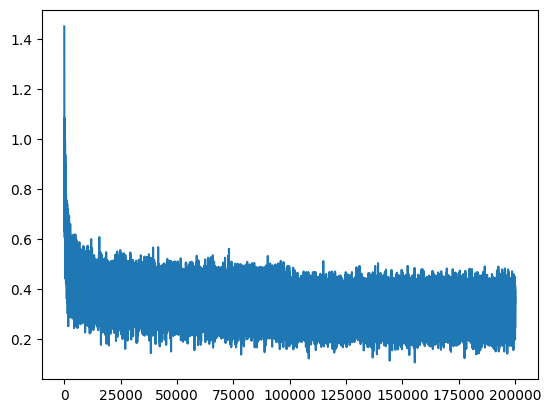

In [ ]:
plt.plot(stepi,lossi);

In [ ]:
emb = C[Xtr] # 32,3,2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32,100
logits = h @ W2 + b2 # 32,27
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.1141, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev] # 32,3,2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32,100
logits = h @ W2 + b2 # 32,27
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1637, grad_fn=<NllLossBackward0>)

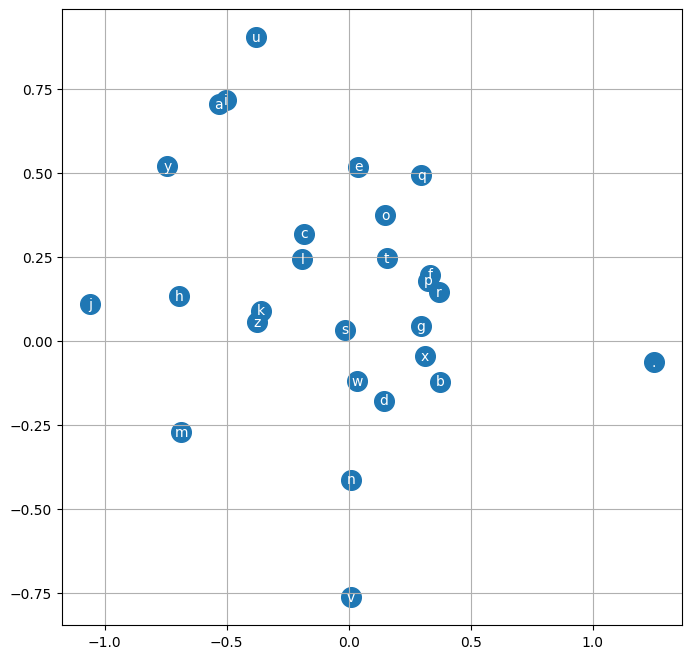

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),iots[i], ha='center', va='center', color='white')
plt.grid('minor')

[<matplotlib.lines.Line2D>]

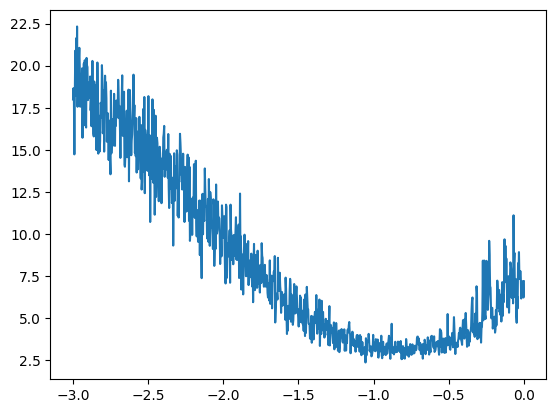

In [ ]:
plt.plot(lri,lossi)# this plot can give as the rough estimate of the good lr

In [ ]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]* block_size # initializing all with ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, num_samples=1, generator =g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix ==0:
            break
            
    print(''.join(iots[i] for i in out ))
        

carmah.
amelle.
khirgleigentleenanden.
jazonen.
deliah.
jareen.
ner.
kiah.
maiir.
kaleigh.
ham.
join.
quint.
sulin.
alian.
quinae.
madiaristin.
jenni.
sabeed.
edi.
